# Image Stegography
* `Importing Modules`

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.cuda.amp import GradScaler, autocast
from pathlib import Path


In [ ]:
# --- Configuration & Paths ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR = os.path.join(os.getcwd(), "drive", "MyDrive", "image steganography")

# Data Directories
TRAIN_DIR = os.path.join(BASE_DIR, "BSDS500", "images", "train")
TEST_DIR = os.path.join(BASE_DIR, "BSDS500", "images", "test")
VAL_DIR = os.path.join(BASE_DIR, "BSDS500", "images", "val")
EDGE_TRAIN_DIR = os.path.join(BASE_DIR, "data", "jpg_edge_images", "train")
EDGE_VAL_DIR = os.path.join(BASE_DIR, "data", "jpg_edge_images", "val")

# Artifact Paths
CHECKPOINT_DIR = os.path.join(BASE_DIR, "artifacts")
MODEL_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "best_model_new.pth")

print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* `Creating dataset`

In [ ]:
class BSDImageNetDataset(Dataset):
    def __init__(self, cover_dir, secret_dir, edge_dir, limit=None, rgb_transform=None, edge_transform=None, val=False):
        self.cover_dir = cover_dir
        self.secret_dir = secret_dir
        self.edge_dir = edge_dir
        self.rgb_transform = rgb_transform
        self.edge_transform = edge_transform

        valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp')
        self.cover_images = sorted([f for f in os.listdir(cover_dir) if f.lower().endswith(valid_extensions)])
        self.secret_images = sorted([f for f in os.listdir(secret_dir) if f.lower().endswith(valid_extensions)])
        self.edge_images = sorted([f for f in os.listdir(edge_dir) if f.lower().endswith(valid_extensions)])

        # Find common image filenames between cover and edge (based on filename without extension)
        cover_names = set([os.path.splitext(f)[0] for f in self.cover_images])
        edge_names = set([os.path.splitext(f)[0] for f in self.edge_images])

        # Get common names between cover and edge directories only
        common_names = list(cover_names.intersection(edge_names))
        common_names.sort()  # Sort for consistency

        # Limit the number of images if specified
        if limit and limit < len(common_names):
            common_names = common_names[:limit]

        # Create filtered lists for cover and edge images
        self.cover_images = [f for f in self.cover_images if os.path.splitext(f)[0] in common_names]
        self.edge_images = [f for f in self.edge_images if os.path.splitext(f)[0] in common_names]

        # For secret images, just take the first 'limit' or use all if no limit
        if limit is not None and limit < len(self.secret_images) and val:
            self.secret_images = self.secret_images[:-limit-1:-1]
        elif limit is not None and limit < len(self.secret_images):
            self.secret_images = self.secret_images[:limit]
        else:
            self.secret_images = self.secret_images[:len(self.cover_images)]

        # Make sure we have exactly the same number of images now
        assert len(self.cover_images) == len(self.secret_images) == len(self.edge_images), \
            f"Failed to match images across directories: cover={len(self.cover_images)}, secret={len(self.secret_images)}, edge={len(self.edge_images)}"

        print(f"Dataset created with {len(self.cover_images)} images (limit={limit})")

    def __len__(self):
        return len(self.cover_images)

    def __getitem__(self, idx):
        cover_path = os.path.join(self.cover_dir, self.cover_images[idx])
        secret_path = os.path.join(self.secret_dir, self.secret_images[idx])
        edge_path = os.path.join(self.edge_dir, self.edge_images[idx])
        cover_name = os.path.basename(cover_path).replace(".jpg", "")

        try:
            cover = Image.open(cover_path).convert('RGB')
            secret = Image.open(secret_path).convert('RGB')
            edge = Image.open(edge_path).convert('L')
        except Exception as e:
            raise RuntimeError(f"Failed to load image at index {idx}: {e}\n"
                              f"Cover: {cover_path}\nSecret: {secret_path}\nEdge: {edge_path}")

        if self.rgb_transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            cover = self.rgb_transform(cover)
            torch.manual_seed(seed)
            secret = self.rgb_transform(secret)
        if self.edge_transform:
            torch.manual_seed(seed)
            edge = self.edge_transform(edge)

        edge = (edge > 0.12).float()  # Binary threshold
        # edge = F.max_pool2d(edge, kernel_size=3, stride=1, padding=1)  # Dilate edges

        return cover, secret, edge, cover_name

* `Testing dataset`

In [ ]:
# Define transforms with augmentation
rgb_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),  # Added augmentation
    transforms.RandomVerticalFlip(p=0.5),    # Added augmentation
    transforms.RandomRotation(10),           # Added augmentation
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
edge_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),  # Added augmentation
    transforms.RandomVerticalFlip(p=0.5),    # Added augmentation
    transforms.RandomRotation(10),           # Added augmentation
    transforms.ToTensor(),  # Edge maps remain in [0, 1]
    # transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

 # Create the dataset
try:
    stego_dataset = BSDImageNetDataset(
        cover_dir=TRAIN_DIR,
        secret_dir=TEST_DIR,
        edge_dir=EDGE_TRAIN_DIR,
        rgb_transform=rgb_transform,
        edge_transform=edge_transform,
        limit=200
    )

    print("StegoDataset created successfully.")
    print(f"Number of samples in dataset: {len(stego_dataset)}")

    # Create a DataLoader
    batch_size = 2
    stego_dataloader = DataLoader(stego_dataset, batch_size=batch_size, shuffle=True)

    # Test the DataLoader by iterating through it
    for i, (cover_batch, secret_batch, edge_batch, cover_names) in enumerate(stego_dataloader):
        print(f"\nBatch {i+1}:")
        print(f"  Edge batch shape: {edge_batch.shape}")
        print(f"  Secret batch shape: {secret_batch.shape}")
        print(f"  Cover batch shape: {cover_batch.shape}")
        print(f"  Cover names: {cover_names}")

        if i == 1:  # Test a couple of batches
            break

    print("\nDataLoader test successful.")

except (ValueError, FileNotFoundError) as e:
    print(f"Error creating or using the dataset/dataloader: {e}")


Dataset created with 200 images (limit=200)
StegoDataset created successfully.
Number of samples in dataset: 200

Batch 1:
  Edge batch shape: torch.Size([2, 1, 256, 256])
  Secret batch shape: torch.Size([2, 3, 256, 256])
  Cover batch shape: torch.Size([2, 3, 256, 256])
  Cover names: ('68077', '153093')

Batch 2:
  Edge batch shape: torch.Size([2, 1, 256, 256])
  Secret batch shape: torch.Size([2, 3, 256, 256])
  Cover batch shape: torch.Size([2, 3, 256, 256])
  Cover names: ('134052', '43070')

DataLoader test successful.


* `Building Network`

In [ ]:
class HideNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Secret Image Encoder (multi-scale features)
        self.secret_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.GroupNorm(8, 32),  # Replace BatchNorm2d
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(16, 64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.GroupNorm(32, 128),
            nn.LeakyReLU(0.2)
        )

        # Edge-Aware Fusion Module
        self.fusion = nn.Sequential(
            nn.Conv2d(128 + 3 + 1, 256, 3, padding=1),  # secret_feat + cover + edge
            nn.GroupNorm(32, 256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.GroupNorm(32, 128),
            nn.LeakyReLU(0.2)
        )

        # Edge-Constrained Decoder (no upsampling, fixed from previous issue)
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.GroupNorm(16, 64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, cover, secret, edge_map):
        # 1. Extract multi-scale secret features
        secret_feat = self.secret_encoder(secret)  # (B, 128, H/4, W/4)
        secret_feat_up = F.interpolate(secret_feat, size=(cover.shape[2], cover.shape[3]), mode='bilinear', align_corners=False)

        # 2. Edge-guided fusion
        x = torch.cat([cover, edge_map, secret_feat_up], dim=1)
        fused = self.fusion(x)

        # 3. Generate edge-constrained modifications
        delta = self.decoder(fused)

        # 4. Strict edge masking
        edge_mask = edge_map.repeat(1, 3, 1, 1)
        stego = cover + delta * edge_mask

        # Return stego and intermediate features for skip connections
        return stego, secret_feat, fused

class RevealNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: stego (3 channels) + edge_map (1 channel) + skip connections (128 from secret_feat + 128 from fused)
        self.net = nn.Sequential(
            nn.Conv2d(3 + 1 + 128 + 128, 256, 3, padding=1),  # Combine stego, edge_map, secret_feat, fused
            nn.GroupNorm(32, 256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.GroupNorm(32, 128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.GroupNorm(16, 64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, stego, edge_map, secret_feat, fused):
        # Upsample secret_feat to match stego dimensions
        secret_feat = F.interpolate(secret_feat, size=(stego.shape[2], stego.shape[3]), mode='bilinear', align_corners=False)
        # Concatenate inputs
        x = torch.cat([stego, edge_map, secret_feat, fused], dim=1)
        return self.net(x)

class SteganoModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hide_network = HideNetwork()
        self.reveal_network = RevealNetwork()

    def forward(self, cover, secret, edge_map):
        stego, secret_feat, fused = self.hide_network(cover, secret, edge_map)
        recovered_secret = self.reveal_network(stego, edge_map, secret_feat, fused)
        return stego, recovered_secret

# Loss Functions
def edge_constrained_loss(stego, cover, edge_map, alpha=10):
    # 1. Content preservation in non-edge regions
    non_edge_mask = 1 - edge_map
    content_loss = F.l1_loss(stego * non_edge_mask, cover * non_edge_mask)

    # 2. Edge modification allowance
    edge_loss = F.l1_loss(stego * edge_map, cover * edge_map)

    return content_loss + alpha * edge_loss

In [ ]:
from torch.cuda.amp import GradScaler, autocast

def train(model, train_loader, val_loader, device, epochs=100, patience=5, accum_steps=2):
    optimizer = optim.Adam(model.parameters(), lr=5e-4)  # Lowered learning rate
    scaler = GradScaler()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6, verbose=True)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        optimizer.zero_grad()

        for i, batch in enumerate(train_loader):
            cover, secret, edge_map, _ = batch
            cover, secret, edge_map = cover.to(device), secret.to(device), edge_map.to(device)

            with autocast():
                stego, secret_feat, fused = model.hide_network(cover, secret, edge_map)
                recovered_secret = model.reveal_network(stego, edge_map, secret_feat, fused)

                loss_stego_train = edge_constrained_loss(stego, cover, edge_map, alpha=10)
                loss_secret_train = F.mse_loss(recovered_secret, secret)
                loss_sparsity_train = 0.01 * torch.mean(torch.abs(stego - cover) * edge_map)
                total_loss_train = (0.5 * loss_stego_train + 3.0 * loss_secret_train + 0.01 * loss_sparsity_train) / accum_steps

            scaler.scale(total_loss_train).backward()

            if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            epoch_train_loss += total_loss_train.item() * accum_steps

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                cover, secret, edge_map, _ = batch
                cover, secret, edge_map = cover.to(device), secret.to(device), edge_map.to(device)
                with autocast():
                    stego, secret_feat, fused = model.hide_network(cover, secret, edge_map)
                    recovered_secret = model.reveal_network(stego, edge_map, secret_feat, fused)
                    loss_stego_val = edge_constrained_loss(stego, cover, edge_map, alpha=10)
                    loss_secret_val = F.mse_loss(recovered_secret, secret)
                    loss_sparsity_val = 0.01 * torch.mean(torch.abs(stego - cover) * edge_map)
                    total_loss_val = 0.5 * loss_stego_val + 3.0 * loss_secret_val + 0.01 * loss_sparsity_val
                epoch_val_loss += total_loss_val.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} => Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Train losses -> loss stego {loss_stego_train:.4f}  loss secret: {loss_secret_train:.4f}  loss sparsity: {loss_sparsity_train:.4f}")
        print(f"Val losses -> loss stego {loss_stego_val:.4f}  loss secret: {loss_secret_val:.4f}  loss sparsity: {loss_sparsity_val:.4f}")
        print(50 * "-")

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved! at epoch: {epoch+1}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}!")
                break

        if epoch % 5 == 0:
            visualize(model, val_loader, device)

    return train_losses, val_losses

def visualize(model, loader, device):
    model.eval()
    with torch.no_grad():
        cover, secret, edge, _ = next(iter(loader))
        cover, secret, edge = cover.to(device), secret.to(device), edge.to(device)

        stego, feat, fused = model.hide_network(cover, secret, edge)
        recovered = model.reveal_network(stego, edge, feat, fused)

        diff = (stego - cover).abs().sum(dim=1, keepdim=True)
        diff = (diff - diff.min()) / (diff.max() - diff.min() + 1e-8)

        images = [cover[0], secret[0], edge[0].squeeze(), stego[0], recovered[0], diff[0].squeeze()]
        titles = ["Cover", "Secret", "Edge", "Stego", "Recovered", "Diff"]

        plt.figure(figsize=(18, 4))
        for i, img in enumerate(images):
            plt.subplot(1, 6, i+1)
            plt.imshow(img.cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5 if img.dim()==3 else img.cpu().numpy(),
                       cmap='gray' if i in [2, 5] else None)
            plt.title(titles[i])
            plt.axis('off')
        plt.show()


* `Creating dataloaders`

In [ ]:
rgb_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.1)
])
edge_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
val_rgb_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
val_edge_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


def create_limited_dataLoader(cover_dir, secret_dir, edge_dir, rgb_transform, edge_transform, limit=None, val=False):
    # Create dataset with limit applied
    dataset = BSDImageNetDataset(
        cover_dir=cover_dir,
        secret_dir=secret_dir,
        edge_dir=edge_dir,
        limit=limit,
        rgb_transform=rgb_transform,
        edge_transform=edge_transform,
        val=val
    )

    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
    return dataloader

print("Creating dataset...")
    # Using the original function for training loader
train_loader = create_limited_dataLoader(TRAIN_DIR, TEST_DIR, EDGE_TRAIN_DIR,
                                rgb_transform, edge_transform, limit=200)
# Using the new function for validation loader with limit of 50
val_loader = create_limited_dataLoader(VAL_DIR, TEST_DIR, EDGE_VAL_DIR,
                                      val_rgb_transform, val_edge_transform, limit=40, val=True)

Creating dataset...
Dataset created with 200 images (limit=200)
Dataset created with 40 images (limit=40)


* `Training the network`

<ipython-input-29-08519053b351>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-29-08519053b351>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-29-08519053b351>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/100 => Train Loss: 0.3093, Val Loss: 0.1627
Train losses -> loss stego 0.0104  loss secret: 0.0441  loss sparsity: 0.0000
Val losses -> loss stego 0.0090  loss secret: 0.0500  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 1


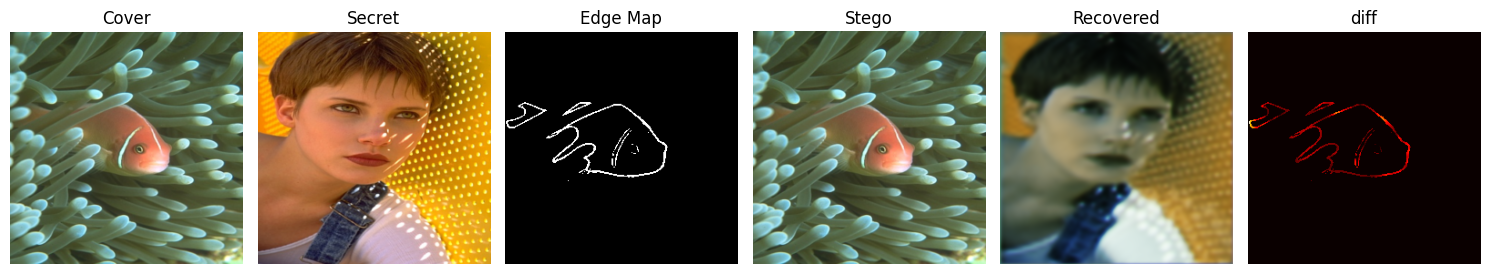

Epoch 2/100 => Train Loss: 0.1210, Val Loss: 0.1184
Train losses -> loss stego 0.0027  loss secret: 0.0334  loss sparsity: 0.0000
Val losses -> loss stego 0.0039  loss secret: 0.0344  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 2
Epoch 3/100 => Train Loss: 0.1012, Val Loss: 0.0865
Train losses -> loss stego 0.0056  loss secret: 0.0318  loss sparsity: 0.0000
Val losses -> loss stego 0.0044  loss secret: 0.0257  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 3
Epoch 4/100 => Train Loss: 0.0808, Val Loss: 0.0643
Train losses -> loss stego 0.0048  loss secret: 0.0230  loss sparsity: 0.0000
Val losses -> loss stego 0.0034  loss secret: 0.0170  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 4
Epoch 5/100 => Train Loss: 0.0794, Val Loss: 0.0668
Train losses -> loss stego 0.0041  loss secret: 0.0281  loss sparsity: 0.0000
Val losses -> loss stego

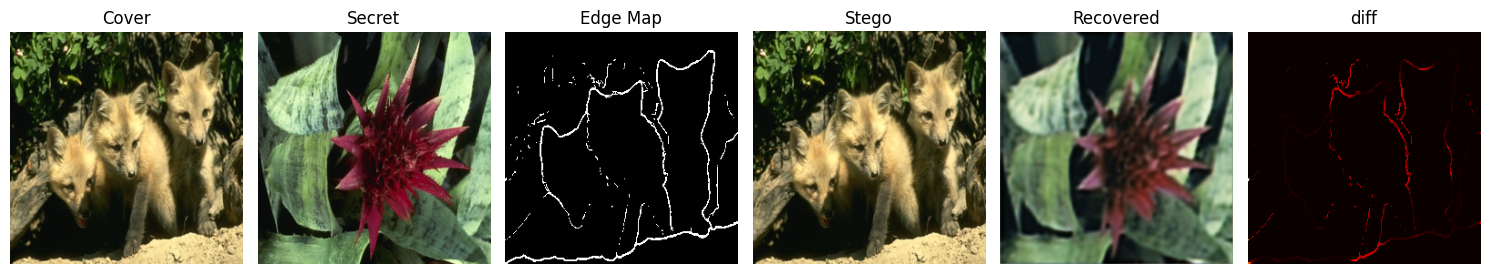

Epoch 7/100 => Train Loss: 0.0607, Val Loss: 0.0544
Train losses -> loss stego 0.0025  loss secret: 0.0120  loss sparsity: 0.0000
Val losses -> loss stego 0.0085  loss secret: 0.0259  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 7
Epoch 8/100 => Train Loss: 0.0546, Val Loss: 0.0510
Train losses -> loss stego 0.0086  loss secret: 0.0154  loss sparsity: 0.0000
Val losses -> loss stego 0.0040  loss secret: 0.0171  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 8
Epoch 9/100 => Train Loss: 0.0462, Val Loss: 0.0539
Train losses -> loss stego 0.0030  loss secret: 0.0090  loss sparsity: 0.0000
Val losses -> loss stego 0.0062  loss secret: 0.0114  loss sparsity: 0.0000
--------------------------------------------------
Epoch 10/100 => Train Loss: 0.0470, Val Loss: 0.0394
Train losses -> loss stego 0.0021  loss secret: 0.0096  loss sparsity: 0.0000
Val losses -> loss stego 0.0021  loss secret: 0.

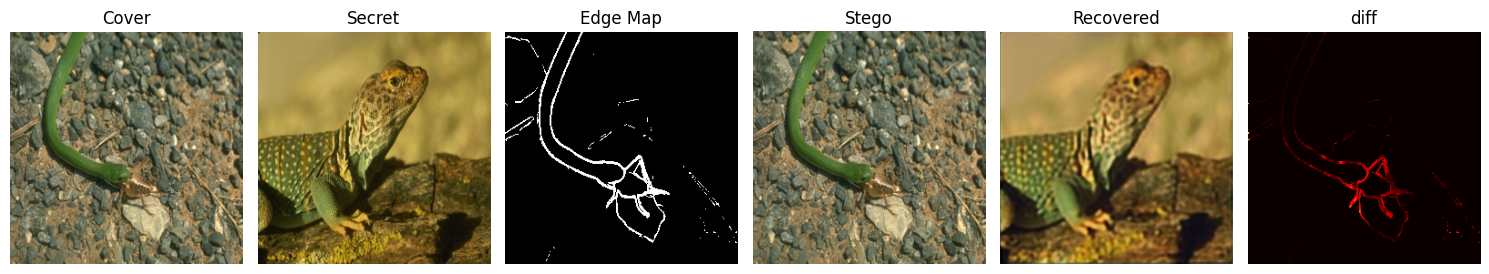

Epoch 12/100 => Train Loss: 0.0391, Val Loss: 0.0351
Train losses -> loss stego 0.0026  loss secret: 0.0169  loss sparsity: 0.0000
Val losses -> loss stego 0.0023  loss secret: 0.0101  loss sparsity: 0.0000
--------------------------------------------------
Epoch 13/100 => Train Loss: 0.0391, Val Loss: 0.0355
Train losses -> loss stego 0.0017  loss secret: 0.0191  loss sparsity: 0.0000
Val losses -> loss stego 0.0027  loss secret: 0.0119  loss sparsity: 0.0000
--------------------------------------------------
Epoch 14/100 => Train Loss: 0.0362, Val Loss: 0.0332
Train losses -> loss stego 0.0017  loss secret: 0.0064  loss sparsity: 0.0000
Val losses -> loss stego 0.0037  loss secret: 0.0090  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 14
Epoch 15/100 => Train Loss: 0.0304, Val Loss: 0.0314
Train losses -> loss stego 0.0015  loss secret: 0.0086  loss sparsity: 0.0000
Val losses -> loss stego 0.0027  loss secret: 0.0117  loss sparsity: 

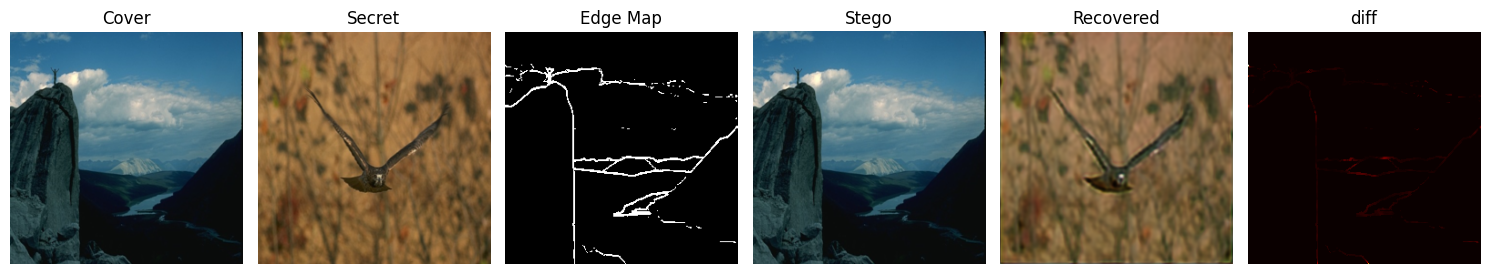

Epoch 17/100 => Train Loss: 0.0307, Val Loss: 0.0292
Train losses -> loss stego 0.0011  loss secret: 0.0127  loss sparsity: 0.0000
Val losses -> loss stego 0.0017  loss secret: 0.0101  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 17
Epoch 18/100 => Train Loss: 0.0290, Val Loss: 0.0258
Train losses -> loss stego 0.0027  loss secret: 0.0092  loss sparsity: 0.0000
Val losses -> loss stego 0.0019  loss secret: 0.0061  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 18
Epoch 19/100 => Train Loss: 0.0291, Val Loss: 0.0274
Train losses -> loss stego 0.0024  loss secret: 0.0108  loss sparsity: 0.0000
Val losses -> loss stego 0.0025  loss secret: 0.0053  loss sparsity: 0.0000
--------------------------------------------------
Epoch 20/100 => Train Loss: 0.0302, Val Loss: 0.0319
Train losses -> loss stego 0.0017  loss secret: 0.0107  loss sparsity: 0.0000
Val losses -> loss stego 0.0033  loss secre

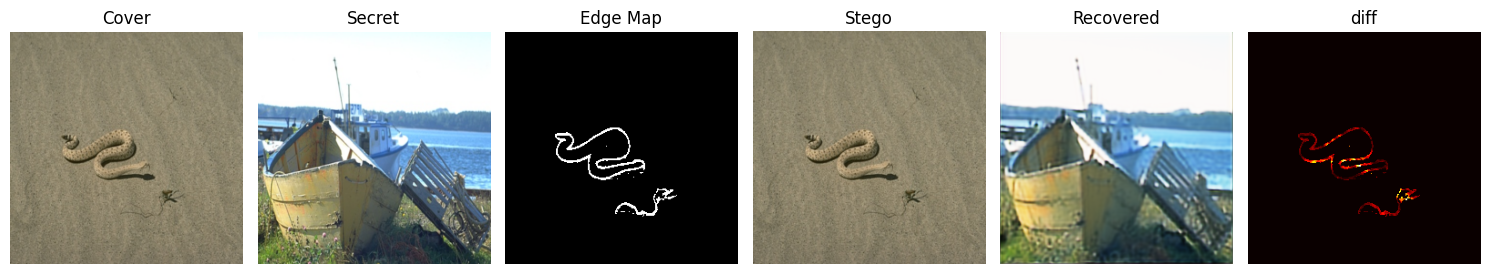

Epoch 22/100 => Train Loss: 0.0295, Val Loss: 0.0272
Train losses -> loss stego 0.0009  loss secret: 0.0073  loss sparsity: 0.0000
Val losses -> loss stego 0.0011  loss secret: 0.0080  loss sparsity: 0.0000
--------------------------------------------------
Epoch 23/100 => Train Loss: 0.0240, Val Loss: 0.0217
Train losses -> loss stego 0.0008  loss secret: 0.0092  loss sparsity: 0.0000
Val losses -> loss stego 0.0011  loss secret: 0.0059  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 23
Epoch 24/100 => Train Loss: 0.0219, Val Loss: 0.0205
Train losses -> loss stego 0.0006  loss secret: 0.0052  loss sparsity: 0.0000
Val losses -> loss stego 0.0007  loss secret: 0.0065  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 24
Epoch 25/100 => Train Loss: 0.0211, Val Loss: 0.0199
Train losses -> loss stego 0.0010  loss secret: 0.0048  loss sparsity: 0.0000
Val losses -> loss stego 0.0011  loss secre

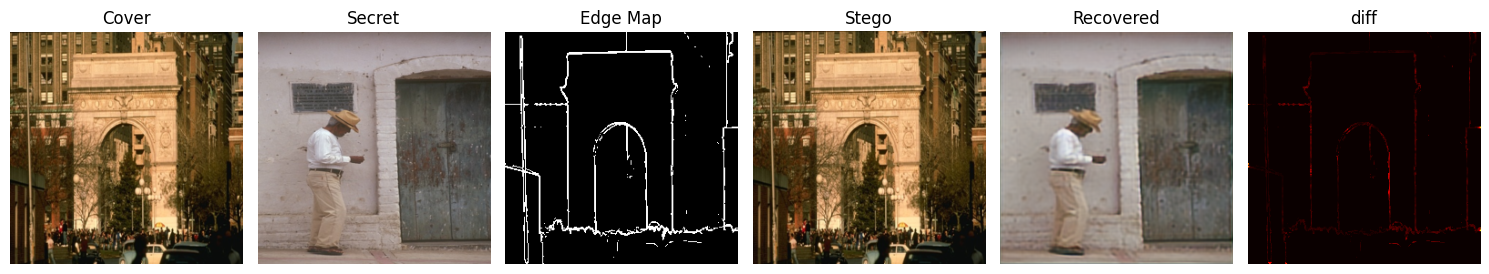

Epoch 27/100 => Train Loss: 0.0193, Val Loss: 0.0189
Train losses -> loss stego 0.0009  loss secret: 0.0073  loss sparsity: 0.0000
Val losses -> loss stego 0.0013  loss secret: 0.0051  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 27
Epoch 28/100 => Train Loss: 0.0197, Val Loss: 0.0188
Train losses -> loss stego 0.0006  loss secret: 0.0088  loss sparsity: 0.0000
Val losses -> loss stego 0.0014  loss secret: 0.0055  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 28
Epoch 29/100 => Train Loss: 0.0205, Val Loss: 0.0200
Train losses -> loss stego 0.0006  loss secret: 0.0042  loss sparsity: 0.0000
Val losses -> loss stego 0.0009  loss secret: 0.0061  loss sparsity: 0.0000
--------------------------------------------------
Epoch 30/100 => Train Loss: 0.0191, Val Loss: 0.0180
Train losses -> loss stego 0.0013  loss secret: 0.0057  loss sparsity: 0.0000
Val losses -> loss stego 0.0010  loss secre

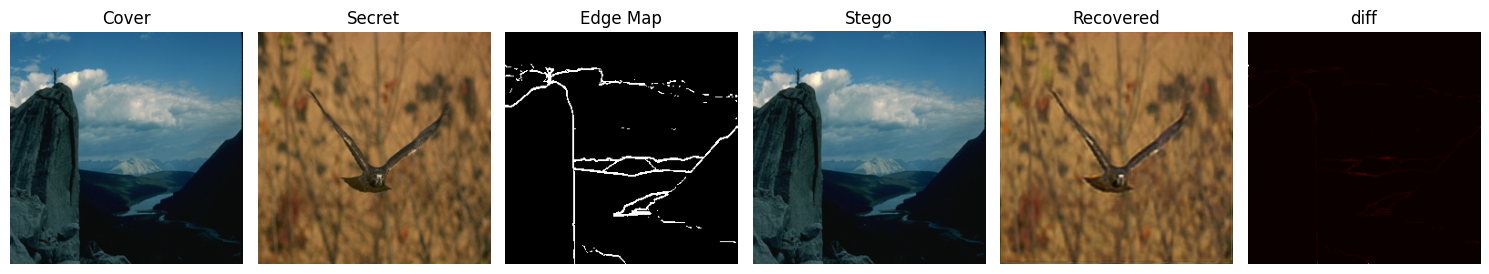

Epoch 32/100 => Train Loss: 0.0184, Val Loss: 0.0175
Train losses -> loss stego 0.0007  loss secret: 0.0041  loss sparsity: 0.0000
Val losses -> loss stego 0.0010  loss secret: 0.0049  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 32
Epoch 33/100 => Train Loss: 0.0183, Val Loss: 0.0166
Train losses -> loss stego 0.0011  loss secret: 0.0031  loss sparsity: 0.0000
Val losses -> loss stego 0.0014  loss secret: 0.0055  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 33
Epoch 34/100 => Train Loss: 0.0166, Val Loss: 0.0162
Train losses -> loss stego 0.0006  loss secret: 0.0069  loss sparsity: 0.0000
Val losses -> loss stego 0.0007  loss secret: 0.0027  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 34
Epoch 35/100 => Train Loss: 0.0178, Val Loss: 0.0165
Train losses -> loss stego 0.0011  loss secret: 0.0048  loss sparsity: 0.0000
Val losses -> los

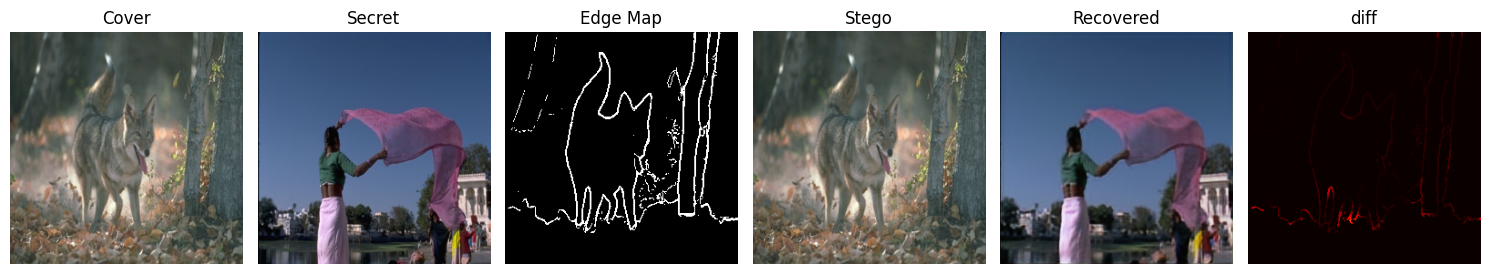

Epoch 37/100 => Train Loss: 0.0174, Val Loss: 0.0164
Train losses -> loss stego 0.0007  loss secret: 0.0048  loss sparsity: 0.0000
Val losses -> loss stego 0.0008  loss secret: 0.0052  loss sparsity: 0.0000
--------------------------------------------------
Epoch 38/100 => Train Loss: 0.0169, Val Loss: 0.0166
Train losses -> loss stego 0.0014  loss secret: 0.0055  loss sparsity: 0.0000
Val losses -> loss stego 0.0013  loss secret: 0.0075  loss sparsity: 0.0000
--------------------------------------------------
Epoch 39/100 => Train Loss: 0.0162, Val Loss: 0.0144
Train losses -> loss stego 0.0010  loss secret: 0.0072  loss sparsity: 0.0000
Val losses -> loss stego 0.0011  loss secret: 0.0046  loss sparsity: 0.0000
--------------------------------------------------
Model saved! at epoch: 39
Epoch 40/100 => Train Loss: 0.0148, Val Loss: 0.0144
Train losses -> loss stego 0.0004  loss secret: 0.0053  loss sparsity: 0.0000
Val losses -> loss stego 0.0006  loss secret: 0.0043  loss sparsity: 

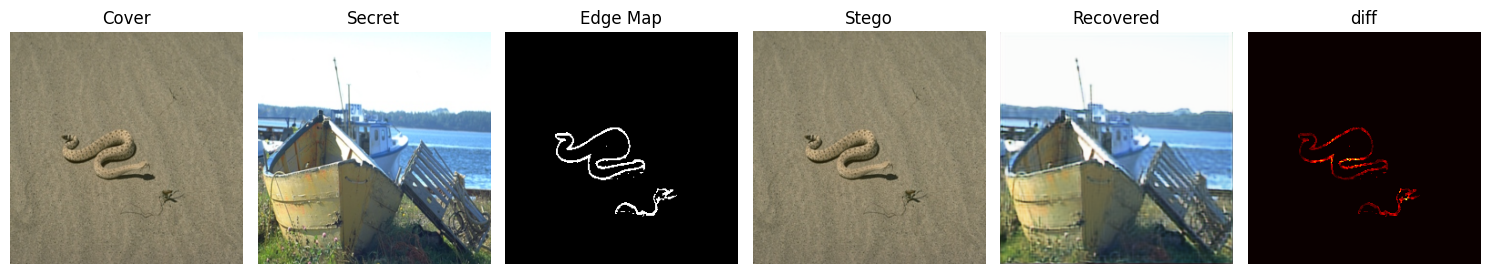

KeyboardInterrupt: 

In [ ]:
# Initialize and train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SteganoModel().to(device)

train_losses, val_losses = train(model, train_loader, val_loader,  device, epochs=100, patience=5)
# plot_losses(train_losses, val_losses)